In [1]:
# !pip install -q scikit-learn==0.23.2 matplotlib==3.1.3 pandas==1.1.3 gensim==3.8.1 torch==1.6.0 torchvision==0.7.0

In [2]:
!wget https://moodle.u-paris.fr/pluginfile.php/512951/mod_resource/content/2/oscar.fr.300.10k.model

--2022-04-15 14:00:36--  https://moodle.u-paris.fr/pluginfile.php/512951/mod_resource/content/2/oscar.fr.300.10k.model
Résolution de moodle.u-paris.fr (moodle.u-paris.fr)… 195.220.128.206, 195.220.128.207
Connexion à moodle.u-paris.fr (moodle.u-paris.fr)|195.220.128.206|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 36565468 (35M) [text/plain]
Sauvegarde en : « oscar.fr.300.10k.model.1 »

oscar.fr.300.10k.mo 100%[===================>]  34,87M  6,98MB/s    ds 5,0s    

2022-04-15 14:00:42 (6,97 MB/s) — « oscar.fr.300.10k.model.1 » sauvegardé [36565468/36565468]



In [3]:
from gensim.models import KeyedVectors
from gensim.utils import tokenize

from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import os, sys
#sys.path.append(os.path.abspath('../../m2-data-sciences/src'))

import matplotlib.pyplot as plt

# set font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

# IPython automatically reload all changed code
%load_ext autoreload
%autoreload 2

# Inline Figures with matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
w2v_model = KeyedVectors.load_word2vec_format("oscar.fr.300.10k.model")
w2v_model.init_sims(replace=True)

In [5]:
len(w2v_model.vocab.items())

10000

In [6]:
# On crée un array avec les 10,000 premiers mots et on crée le dictionaire de vocabulaire
idx2w = {i: w for (i, w) in enumerate(w2v_model.vocab)}
w2idx = {w: i for (i, w) in enumerate(w2v_model.vocab)}

embeddings_vectors = [w2v_model[w] for w in w2v_model.vocab]
word2vec_embeddings = np.vstack(embeddings_vectors)

In [7]:
# word2vec_embeddings

In [8]:
print(word2vec_embeddings.shape)

(10000, 300)


### Ouvrir le dataframe

In [111]:
df = pd.read_csv('/Users/princek/Desktop/IPSSI/Projet ML/emojis.csv',index_col=[0,1])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6387 entries, (1, 4) to (7370, 23195)
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sms         6299 non-null   object
 1   happy       6387 non-null   bool  
 2   joke        6387 non-null   bool  
 3   astonished  6387 non-null   bool  
 4   angry       6387 non-null   bool  
 5   bored       6387 non-null   bool  
 6   heart       6387 non-null   bool  
 7   filter      6387 non-null   bool  
 8   tokens      6387 non-null   object
dtypes: bool(7), object(2)
memory usage: 908.3+ KB


In [11]:
df.head()

,,sms,happy,joke,astonished,angry,bored,heart,filter,tokens
,Unnamed: 0.1,,,,,,,,,
1,4,Oh trop mignon mon bbé jsuis au travaiiiil la,False,False,False,False,False,True,True,"['Oh', 'trop', 'mignon', 'mon', 'bbé', 'jsuis'..."
3,6,Mon cher et tendre filleul... Je m'engage a et...,False,False,False,False,False,True,True,"['Mon', 'cher', 'et', 'tendre', 'filleul', '....."
4,7,Ohhhhhh non ! Héhé j'te texto en mode scred mo...,False,False,False,False,False,True,True,"['Ohhhhhh', 'non', '!', 'Héhé', ""j'"", 'te', 't..."
6,11,Non chez mon arriere grand mere juste a coté d...,False,True,False,False,False,False,True,"['Non', 'chez', 'mon', 'arriere', 'grand', 'me..."
7,14,Demain jai deux heures de pause si tu veux on ...,False,True,False,False,False,False,True,"['Demain', 'jai', 'deux', 'heures', 'de', 'pau..."


In [12]:
df.index

MultiIndex([(   1,     4),
            (   3,     6),
            (   4,     7),
            (   6,    11),
            (   7,    14),
            (  10,    21),
            (  11,    23),
            (  12,    24),
            (  13,    25),
            (  14,    27),
            ...
            (7359, 23170),
            (7360, 23171),
            (7361, 23174),
            (7363, 23177),
            (7365, 23182),
            (7366, 23183),
            (7367, 23184),
            (7368, 23186),
            (7369, 23193),
            (7370, 23195)],
           names=[None, 'Unnamed: 0.1'], length=6387)

In [13]:
df.isnull().sum()

sms           88
happy          0
joke           0
astonished     0
angry          0
bored          0
heart          0
filter         0
tokens         0
dtype: int64

In [14]:
df=df.dropna()

In [15]:
df = df.drop(['tokens'], axis = 1)

In [16]:
df.head()

,,sms,happy,joke,astonished,angry,bored,heart,filter
,Unnamed: 0.1,,,,,,,,
1,4,Oh trop mignon mon bbé jsuis au travaiiiil la,False,False,False,False,False,True,True
3,6,Mon cher et tendre filleul... Je m'engage a et...,False,False,False,False,False,True,True
4,7,Ohhhhhh non ! Héhé j'te texto en mode scred mo...,False,False,False,False,False,True,True
6,11,Non chez mon arriere grand mere juste a coté d...,False,True,False,False,False,False,True
7,14,Demain jai deux heures de pause si tu veux on ...,False,True,False,False,False,False,True


In [17]:
df.shape

(6299, 8)

In [18]:
classes = ['happy', 'joke', 'angry', 'heart']

In [19]:
df.isnull().sum(axis=0)

sms           0
happy         0
joke          0
astonished    0
angry         0
bored         0
heart         0
filter        0
dtype: int64

In [20]:
df['sms'].isnull().sum(axis = 0)

0

In [21]:
df.isnull().sum(axis=0)

sms           0
happy         0
joke          0
astonished    0
angry         0
bored         0
heart         0
filter        0
dtype: int64

In [22]:
df.head()

,,sms,happy,joke,astonished,angry,bored,heart,filter
,Unnamed: 0.1,,,,,,,,
1,4,Oh trop mignon mon bbé jsuis au travaiiiil la,False,False,False,False,False,True,True
3,6,Mon cher et tendre filleul... Je m'engage a et...,False,False,False,False,False,True,True
4,7,Ohhhhhh non ! Héhé j'te texto en mode scred mo...,False,False,False,False,False,True,True
6,11,Non chez mon arriere grand mere juste a coté d...,False,True,False,False,False,False,True
7,14,Demain jai deux heures de pause si tu veux on ...,False,True,False,False,False,False,True


In [23]:
print(df.shape)

(6299, 8)


In [24]:
df['tokens'] = df['sms'].apply(lambda x:list(tokenize(x)))


In [25]:
df.head()

,,sms,happy,joke,astonished,angry,bored,heart,filter,tokens
,Unnamed: 0.1,,,,,,,,,
1,4,Oh trop mignon mon bbé jsuis au travaiiiil la,False,False,False,False,False,True,True,"[Oh, trop, mignon, mon, bbé, jsuis, au, travai..."
3,6,Mon cher et tendre filleul... Je m'engage a et...,False,False,False,False,False,True,True,"[Mon, cher, et, tendre, filleul, Je, m, engage..."
4,7,Ohhhhhh non ! Héhé j'te texto en mode scred mo...,False,False,False,False,False,True,True,"[Ohhhhhh, non, Héhé, j, te, texto, en, mode, s..."
6,11,Non chez mon arriere grand mere juste a coté d...,False,True,False,False,False,False,True,"[Non, chez, mon, arriere, grand, mere, juste, ..."
7,14,Demain jai deux heures de pause si tu veux on ...,False,True,False,False,False,False,True,"[Demain, jai, deux, heures, de, pause, si, tu,..."


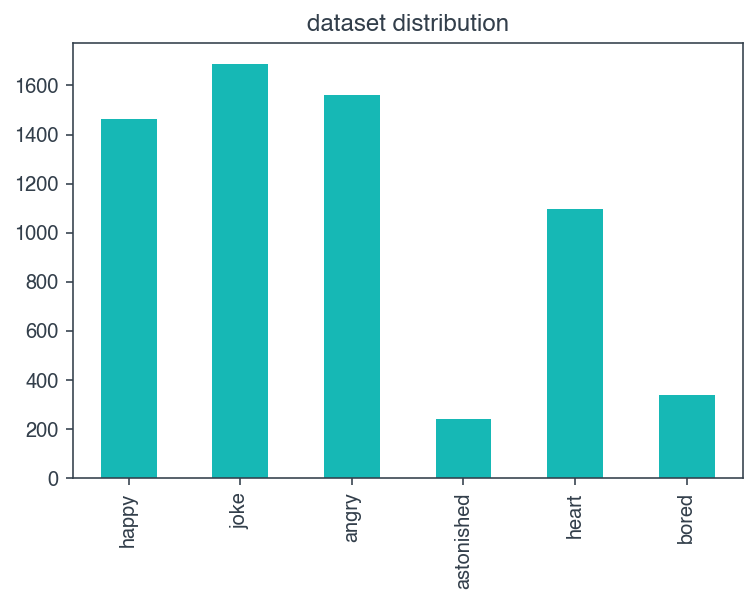

In [112]:
df[["happy", "joke", "angry","astonished" ,"heart","bored"]].sum().plot.bar(color='#16b8b5', title="dataset distribution");

### EDA

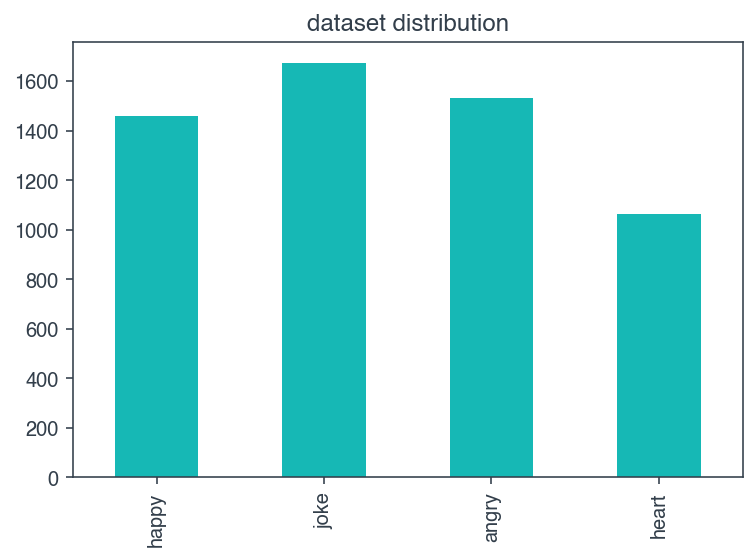

In [26]:
#Le distribution des classes
df[["happy", "joke", "angry", "heart"]].sum().plot.bar(color='#16b8b5', title="dataset distribution");

In [27]:
df.bored.sort_values().sum()

334

In [28]:
query=df.bored!=1
df=df[query]

In [29]:
query=df.astonished!=1
df=df[query]

In [30]:
df.shape

(5725, 9)

In [31]:
df.head()

,,sms,happy,joke,astonished,angry,bored,heart,filter,tokens
,Unnamed: 0.1,,,,,,,,,
1,4,Oh trop mignon mon bbé jsuis au travaiiiil la,False,False,False,False,False,True,True,"[Oh, trop, mignon, mon, bbé, jsuis, au, travai..."
3,6,Mon cher et tendre filleul... Je m'engage a et...,False,False,False,False,False,True,True,"[Mon, cher, et, tendre, filleul, Je, m, engage..."
4,7,Ohhhhhh non ! Héhé j'te texto en mode scred mo...,False,False,False,False,False,True,True,"[Ohhhhhh, non, Héhé, j, te, texto, en, mode, s..."
6,11,Non chez mon arriere grand mere juste a coté d...,False,True,False,False,False,False,True,"[Non, chez, mon, arriere, grand, mere, juste, ..."
7,14,Demain jai deux heures de pause si tu veux on ...,False,True,False,False,False,False,True,"[Demain, jai, deux, heures, de, pause, si, tu,..."


In [32]:
df.shape

(5725, 9)

In [33]:
df=df.drop(['astonished','bored'], 1)

In [34]:
df.head(2)

,,sms,happy,joke,angry,heart,filter,tokens
,Unnamed: 0.1,,,,,,,
1,4,Oh trop mignon mon bbé jsuis au travaiiiil la,False,False,False,True,True,"[Oh, trop, mignon, mon, bbé, jsuis, au, travai..."
3,6,Mon cher et tendre filleul... Je m'engage a et...,False,False,False,True,True,"[Mon, cher, et, tendre, filleul, Je, m, engage..."


In [35]:
tokens_in_voc = []

for sms in df['tokens']:
    for t in sms:
        tokens_in_voc.append(t in w2idx)

print(f"On a {sum(tokens_in_voc) / len(tokens_in_voc) * 100} % des tokens qui ont des embeddings")

On a 85.30596955628455 % des tokens qui ont des embeddings


### representer un sms par un seul embedding

In [36]:
class Vectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, agg_method='mean'):
        self.agg_method = agg_method

    def vectorize(self, tokens):

        vectors = np.array([w2v_model[t] for t in tokens if t in w2v_model.vocab])

        if len(vectors) == 0:
            sentence_embedding = np.zeros_like(w2v_model['roi'])
        elif len(vectors) == 1:
            sentence_embedding = np.squeeze(vectors)
        elif len(vectors) > 1:
            if self.agg_method == 'mean':
                sentence_embedding = np.mean(vectors, axis=0)
            elif self.agg_method == 'max':
                sentence_embedding = np.max(vectors, axis=0)
            elif self.agg_method == 'sum':
                sentence_embedding = np.sum(vectors, axis=0)
        return sentence_embedding



    def fit(self, X):
        X = [self.vectorize(t) for t in X['tokens']]
        X = np.array(X)
        return X

In [37]:
vectorizer = Vectorizer(agg_method='mean')
X = vectorizer.fit(df)
X.shape

(5725, 300)

### Classification

# LogisticRegression

In [39]:
X_train, X_test = train_test_split(
    df, test_size=0.33, random_state=42)

y_train = X_train[['happy', 'joke', 'angry', 'heart']].astype(int).values
y_train = [x.tolist().index(1) for x in y_train]

y_test = X_test[['happy', 'joke', 'angry', 'heart']].astype(int).values
y_test = [x.tolist().index(1) for x in y_test]

In [40]:
X_train.shape

(3835, 7)

In [113]:
X_train[:2]
y_train



[3,
 2,
 3,
 1,
 2,
 1,
 2,
 2,
 0,
 1,
 2,
 3,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 3,
 1,
 2,
 2,
 3,
 1,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 0,
 0,
 3,
 1,
 2,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 3,
 3,
 2,
 0,
 3,
 0,
 2,
 3,
 0,
 1,
 3,
 1,
 1,
 3,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 0,
 2,
 1,
 2,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 2,
 0,
 3,
 0,
 3,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 1,
 2,
 2,
 1,
 0,
 0,
 2,
 3,
 0,
 3,
 0,
 2,
 0,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 3,
 0,
 2,
 0,
 2,
 0,
 2,
 3,
 3,
 2,
 0,
 1,
 1,
 3,
 1,
 0,
 0,
 3,
 1,
 3,
 1,
 1,
 0,
 1,
 1,
 1,
 3,
 3,
 0,
 2,
 3,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 1,
 1,
 2,
 1,
 2,
 1,
 3,
 3,
 0,
 1,
 3,
 1,
 1,
 0,
 0,
 0,
 2,
 3,
 1,
 3,
 0,
 0,
 3,
 3,
 0,
 2,
 0,
 3,
 3,
 0,
 0,
 0,
 2,
 3,
 3,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 2,
 2,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 1,
 3,
 0,
 1,


In [42]:
# vectorize(df['tokens'][0], agg_method='mean')

In [43]:
# X_train.head()

In [44]:
vectorizer = Vectorizer(agg_method='max')
X_train_vec = vectorizer.fit(X_train)
X_train_vec.shape

X_test_vec = vectorizer.fit(X_test)
X_test_vec.shape

(1890, 300)

In [45]:
clf = LogisticRegression(random_state=0,solver='newton-cg', multi_class='multinomial').fit(X_train_vec, y_train)
# Infering data on test set
prediction_LogReg = clf.predict(X_test_vec)
print(prediction_LogReg)

[0 1 2 ... 1 1 0]


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


#  Kmeans

In [47]:
df_k= df

In [48]:
df_k[:2]

,,sms,happy,joke,angry,heart,filter,tokens
,Unnamed: 0.1,,,,,,,
1,4,Oh trop mignon mon bbé jsuis au travaiiiil la,False,False,False,True,True,"[Oh, trop, mignon, mon, bbé, jsuis, au, travai..."
3,6,Mon cher et tendre filleul... Je m'engage a et...,False,False,False,True,True,"[Mon, cher, et, tendre, filleul, Je, m, engage..."


In [49]:
df_k_cat= df_k.drop(['sms','filter','tokens'], axis=1)

In [50]:
df_k_cat.head()

,,happy,joke,angry,heart
,Unnamed: 0.1,,,,
1,4,False,False,False,True
3,6,False,False,False,True
4,7,False,False,False,True
6,11,False,True,False,False
7,14,False,True,False,False


In [51]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit([False,True])

LabelEncoder()

In [52]:
le.classes_

array([False,  True])

In [53]:
cols=["happy", "joke", "angry", "heart"]
df_k_cat[cols]=df_k_cat[cols].apply(le.transform)

In [54]:
df_k_cat[:2]

,,happy,joke,angry,heart
,Unnamed: 0.1,,,,
1,4,0,0,0,1
3,6,0,0,0,1


In [55]:
correlation= df_k_cat.corr()

In [56]:
#sns.heatmap(correlation, cmap='viridis', annot=True)

##Mis à l'échelle de nos donnéees vecteurs

In [57]:

min_max = MinMaxScaler()
min_max

df_minmax = min_max.fit_transform(X_train_vec)
df_minmax.shape
# pd.DataFrame(df_minmax, columns = df.columns, index=df.index).boxplot(rot = 45)


(3835, 300)

In [58]:
pd.DataFrame(df_minmax).describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,...,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000
mean,0.522807,0.637008,0.663352,0.623616,0.598143,0.763278,0.682752,0.684155,0.569724,0.599085,...,0.564867,0.621693,0.671583,0.709817,0.664533,0.613131,0.565579,0.673897,0.499679,0.703202
std,0.118957,0.157786,0.163876,0.118632,0.179351,0.162978,0.132083,0.129963,0.145644,0.139588,...,0.124664,0.167335,0.129548,0.113527,0.153322,0.153187,0.144097,0.147035,0.110634,0.197630
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.448496,0.528359,0.566647,0.560382,0.458790,0.679744,0.613911,0.616314,0.471675,0.511499,...,0.481618,0.507431,0.583023,0.640087,0.584359,0.519443,0.451431,0.590191,0.409347,0.577369
50%,0.534503,0.676158,0.663225,0.633623,0.617906,0.786047,0.699637,0.680817,0.568803,0.583427,...,0.585066,0.617102,0.677312,0.733457,0.677173,0.616876,0.567038,0.707380,0.526347,0.652696
75%,0.618916,0.757276,0.776621,0.707246,0.751688,0.889025,0.800524,0.765198,0.667372,0.705365,...,0.636664,0.712681,0.763538,0.773153,0.772180,0.732563,0.698459,0.778922,0.576434,0.907934
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
from sklearn import cluster
kmeans_minmax = cluster.KMeans(n_clusters=4, random_state=42)
kmeans_minmax
kmeans_minmax.fit(df_minmax)

KMeans(n_clusters=4, random_state=42)

In [60]:
kmeans_minmax.labels_

array([3, 2, 2, ..., 0, 2, 0], dtype=int32)

In [61]:
kmeans_minmax.n_iter_

24

In [62]:
kmeans_minmax.inertia_

12809.4248046875

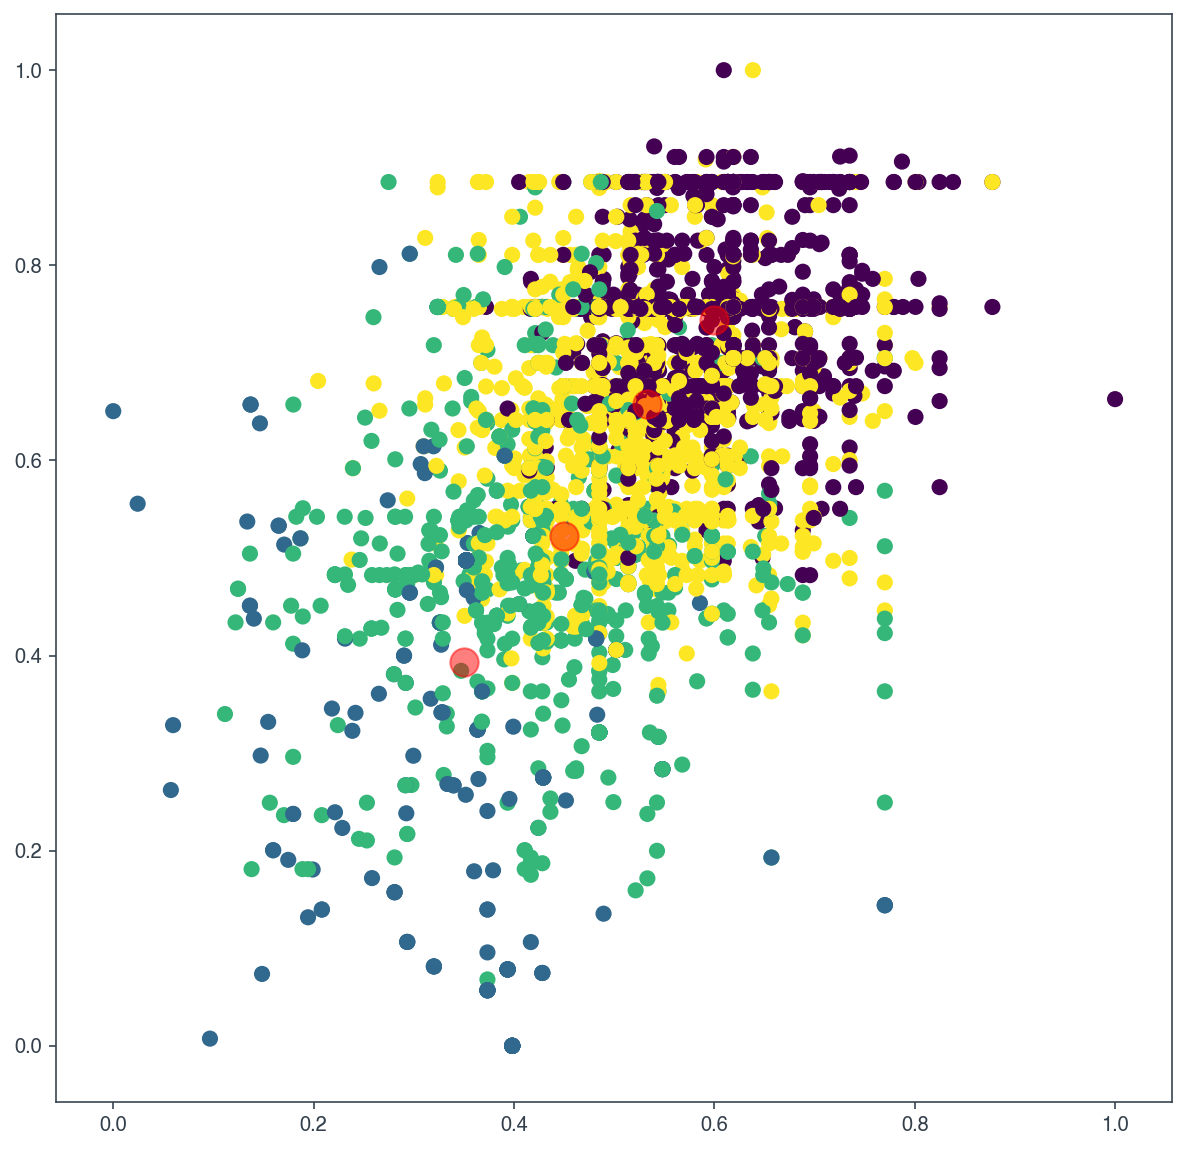

In [63]:
y_kmeans = kmeans_minmax.predict(df_minmax)
y_kmeans
centers = kmeans_minmax.cluster_centers_

plt.figure(figsize=(10,10))
plt.scatter(df_minmax[ : , 0], df_minmax[ : , 1], c=y_kmeans, s=50, cmap='viridis')
# colmap = {1: 'r', 2: 'g', 3: 'b', 4: 'y'}
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)

In [64]:
y_kmeans.shape

(3835,)

*** For n_clusters = 1, inertia is 22829.517578125 ***

*** For n_clusters = 2, inertia is 15620.49609375 ***

*** For n_clusters = 3, inertia is 13527.1796875 ***

*** For n_clusters = 4, inertia is 12809.4248046875 ***

*** For n_clusters = 5, inertia is 12428.5302734375 ***



Text(0.5, 1.0, 'Optimal nb of clusters')

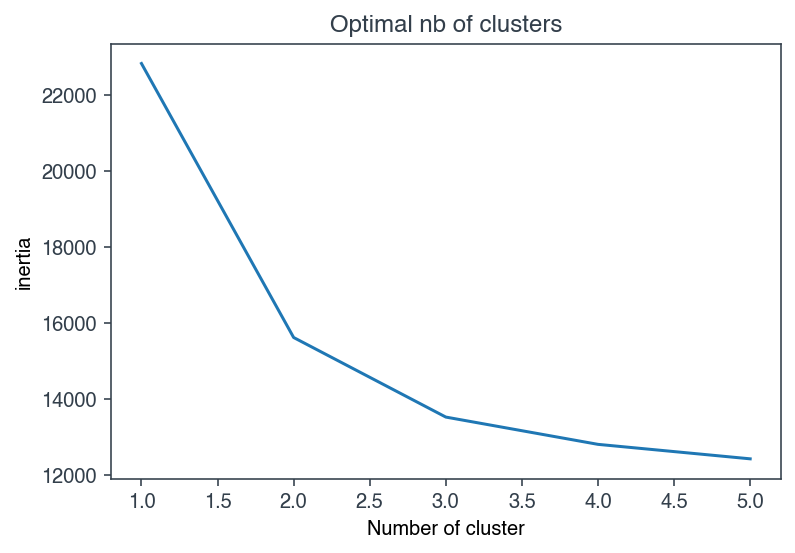

In [65]:
scores = {}
for k in range(1, 6):
    km = cluster.KMeans(n_clusters=k, random_state=42)
    km.fit(df_minmax)
    scores[k] = km.inertia_
    print(f'*** For n_clusters = {k}, inertia is {km.inertia_} ***\n')
plt.figure()
plt.plot(list(scores.keys()), list(scores.values()))
plt.xlabel("Number of cluster")
plt.ylabel("inertia")
plt.title("Optimal nb of clusters")

In [66]:
matrix = confusion_matrix(y_kmeans, y_train)
matrix

array([[322, 364, 369, 196],
       [ 89,  71,  79,  95],
       [181, 218, 148, 183],
       [390, 471, 425, 234]])

(<Figure size 720x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f84dc2004c0>)

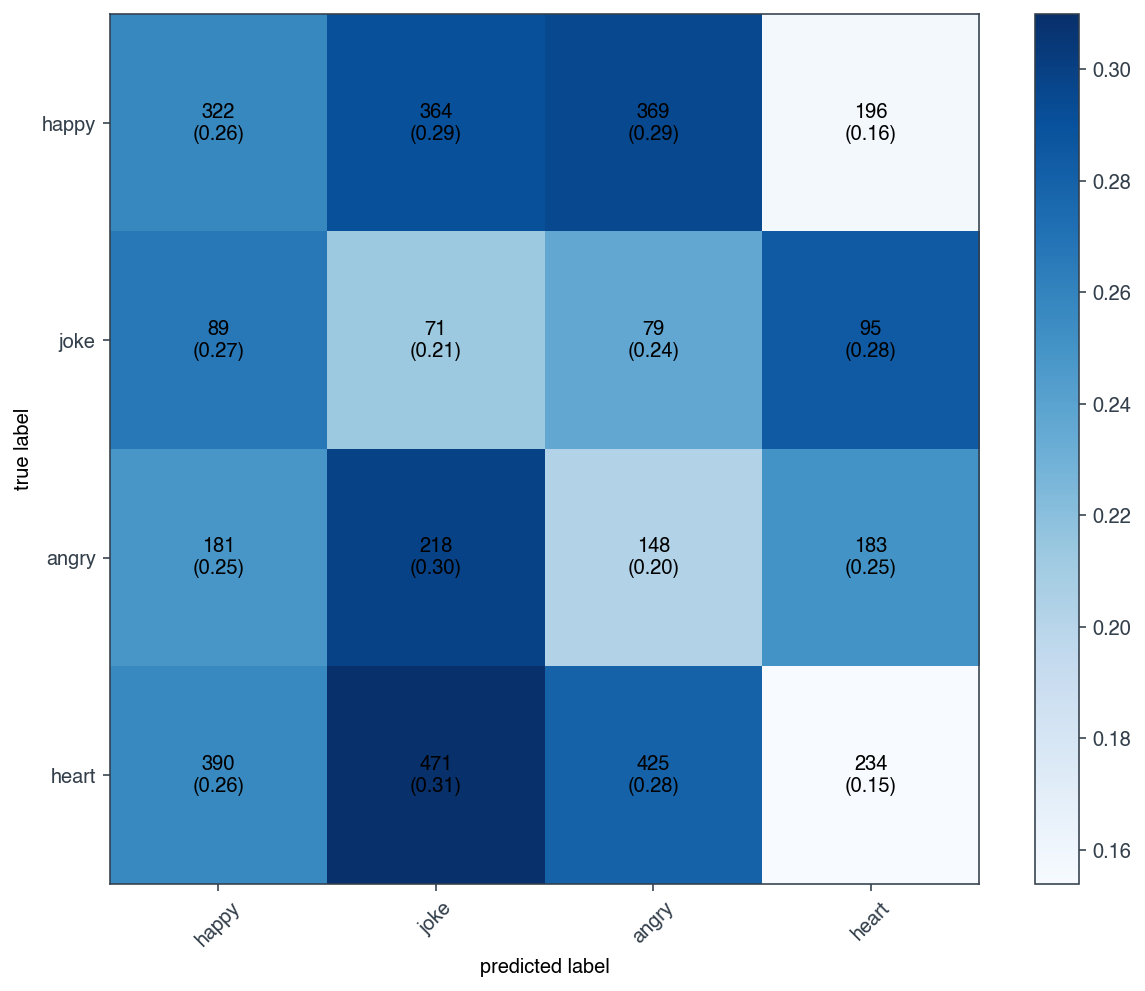

In [67]:
plot_confusion_matrix(conf_mat=matrix,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True, class_names=classes, figsize=(10,8))

In [68]:
y_kmeans


array([3, 2, 2, ..., 0, 2, 0], dtype=int32)

## Random forest

In [69]:
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [70]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf

RandomForestClassifier(n_jobs=-1, random_state=42)

In [71]:
rf.fit(X_train_vec, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [72]:
rf.n_estimators

100

In [103]:
y_pred = rf.predict(X_test_vec)
#y_pred

In [104]:
#y_test

In [75]:
 conf_mat = metrics.confusion_matrix(y_test, y_pred)

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f84bcaf1700>)

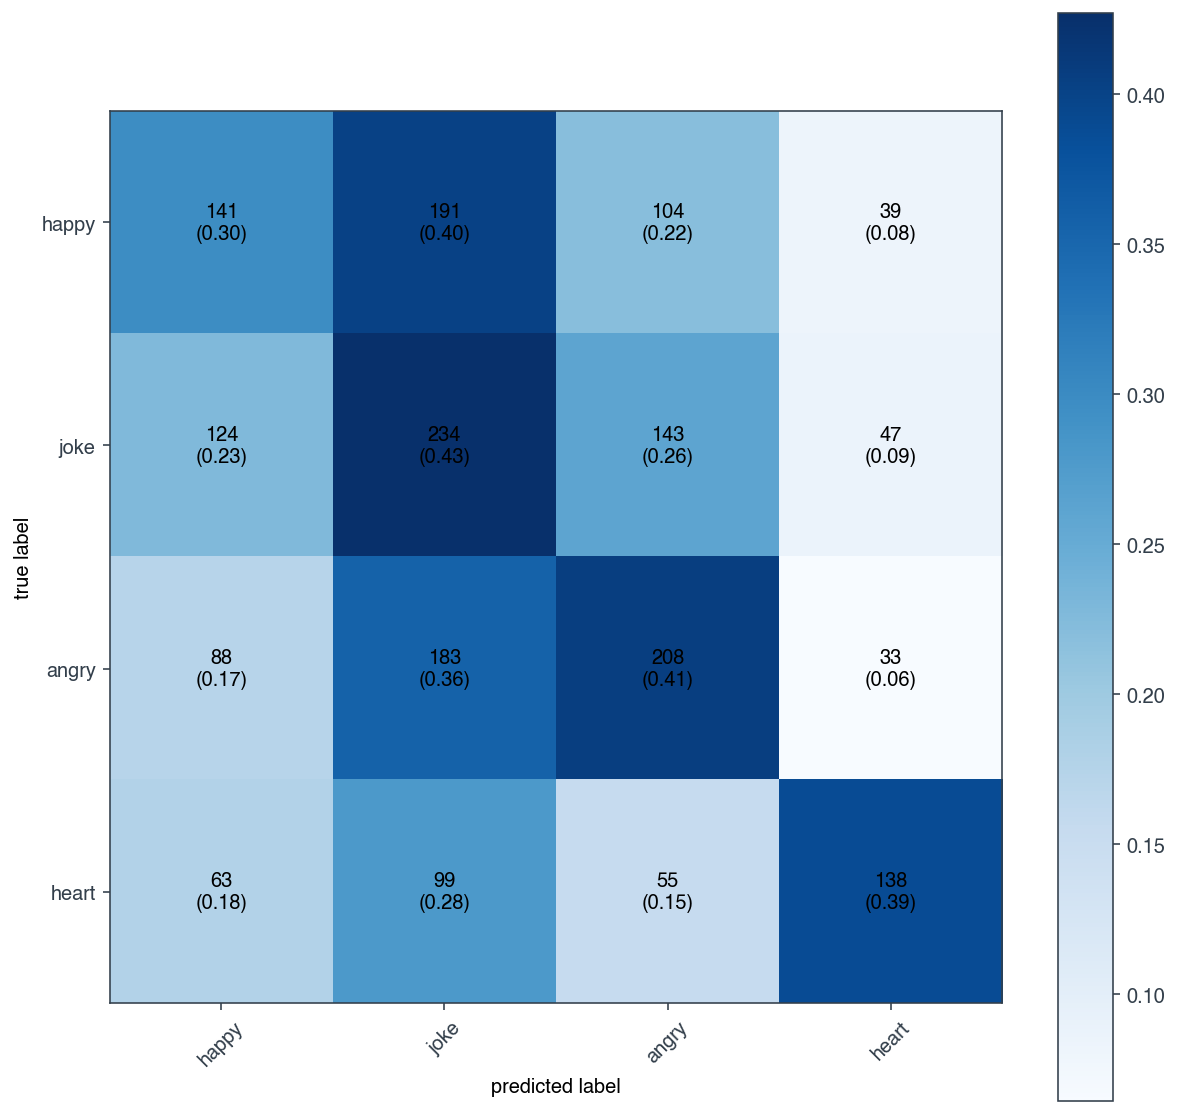

In [76]:
plot_confusion_matrix(conf_mat=conf_mat,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=classes, figsize= (10,10))

## KNN

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [110]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_vec, y_train)
y_pred = knn.predict(X_test_vec)

print(metrics.confusion_matrix(y_test, y_pred)) 

[[203 110 111  51]
 [203 166 125  54]
 [172 123 168  49]
 [141  58  58  98]]


In [82]:
 conf_mat = metrics.confusion_matrix(y_test, y_pred)

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f84d73e1280>)

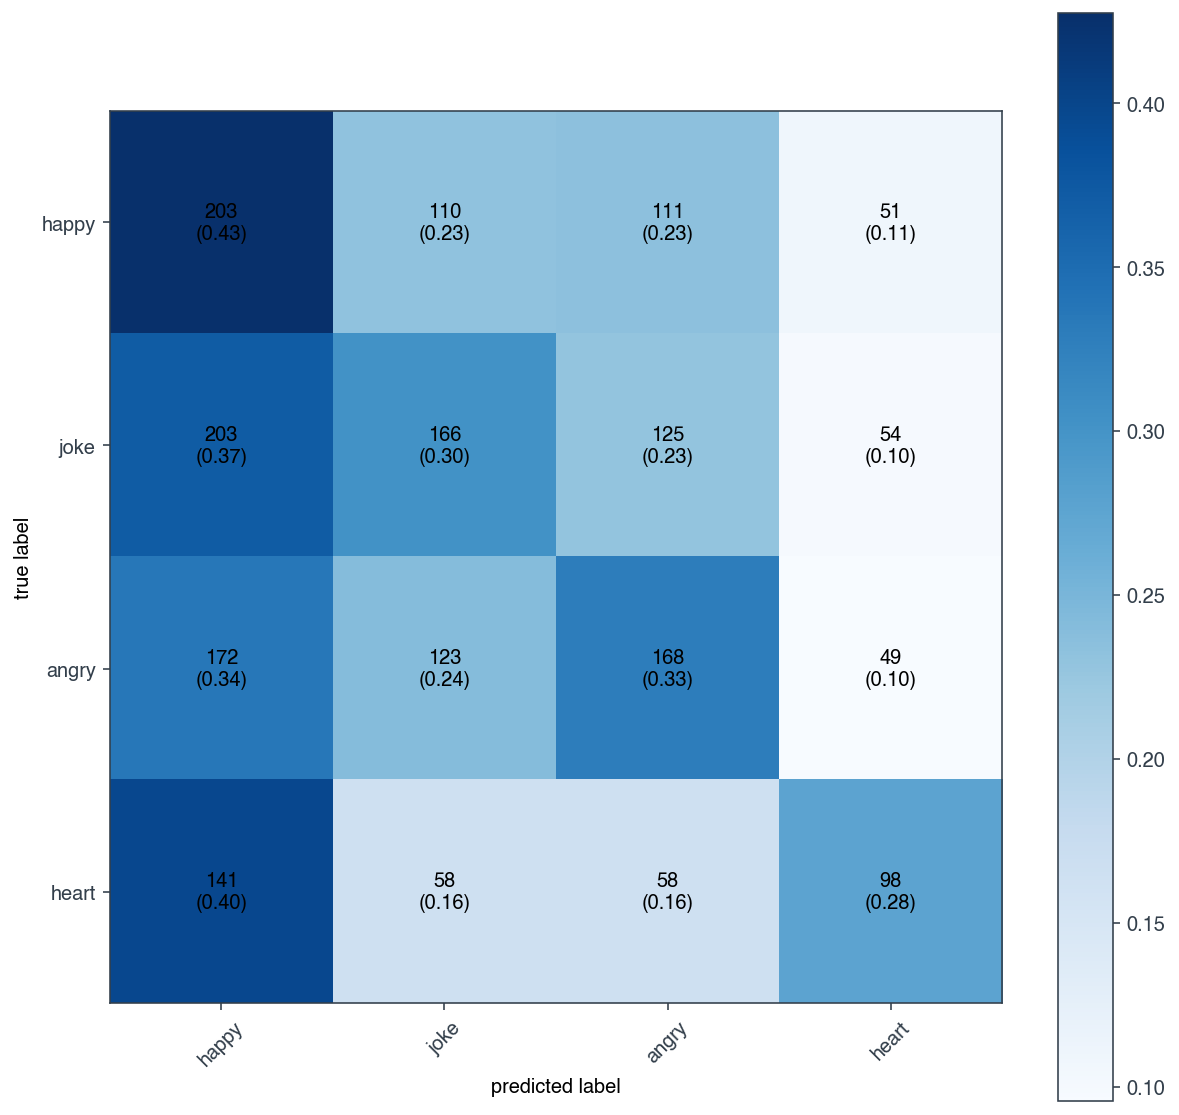

In [83]:
plot_confusion_matrix(conf_mat=conf_mat,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=classes, figsize= (10,10))

## Comparaison entre la prediction et le reel (logreg et RF)

In [84]:
humors = ['happy', 'angry', 'joke', 'heart']
meta_smiley = [b'\xF0\x9F\x98\x83'.decode("utf-8"),
                b'\xF0\x9F\x98\xA0'.decode("utf-8"),
                b'\xF0\x9F\x98\x86'.decode("utf-8"),
                b'\xF0\x9F\x98\x8D'.decode("utf-8")]
humor_2_emoji = {h: ms for (h, ms) in zip(humors, meta_smiley)}

In [85]:
prediction_LogReg = clf.predict(X_test_vec)

In [86]:
for _ in range(8):
    idx = np.random.randint(0, len(X_test))
    
    emojis = humor_2_emoji[classes[prediction_LogReg[idx]]]
    
    true_emojis = humor_2_emoji[classes[y_test[idx]]]
    print(X_test['sms'].values[idx], '(Pred)', emojis, '(True)', true_emojis, '\n')

Très bien! [_forename_] va venir au vert anglais et [_forename_] nous rejoindra aussi ca te dérange ou pas? Au pire on pourra s'isoler pr parler (Pred) 😠 (True) 😃 

Celui pour dans deux semaines ! Ta dis que tu maiderais... ' (Pred) 😃 (True) 😆 

Juste une pensée pour pas que tu oublie combien ont t'aime courage . . . Bisou tt plein de nous 5. (Pred) 😠 (True) 😆 

Super (Pred) 😃 (True) 😆 

Bah je sais pas! Je savais meme pas quon pouvait le desactiver ... Dun coté je msuis endormie avec mon ordi hier soir... (Pred) 😠 (True) 😆 

Je vais regarder plus en détail le travail de [_forename_] et je te redirai. pour la physique je n'ai que survolé le Dm donc je ne peux pas t'aider et pour la chimie comment tu fais pour trouver le degré d'oxydation? (Pred) 😃 (True) 😠 

vous faites quoi? (Pred) 😃 (True) 😃 

Ta vu le temps qu'il annonce cette semaine ! On à l'été indien (Pred) 😆 (True) 😃 



In [87]:
prediction_rf = rf.predict(X_test_vec)

In [88]:
for _ in range(8):
    idx = np.random.randint(0, len(X_test))
    
    emojis = humor_2_emoji[classes[prediction_rf[idx]]]
    
    true_emojis = humor_2_emoji[classes[y_test[idx]]]
    print(X_test['sms'].values[idx], '(Pred)', emojis, '(True)', true_emojis, '\n')

Bon j'te laisse, y a ma copine Bisous (Pred) 😆 (True) 😃 

Et bien les cinémas gaumont m'offrent une place gratuite pour mon anniversaire mais valable juste aujourd'hui donc là je viens de faire quelques cadeaux -enfin deux..- je vais faire des photocopies et après j'irai voir mon film (Pred) 😃 (True) 😃 

Oui! Je viendrais te les amener chez toi en revenant de cours!!=DD (Pred) 😃 (True) 😍 

J'y pense pas. Je suis juste triste . Sans penser . Juste très triste Je t'aime (Pred) 😠 (True) 😠 

Merci (Pred) 😍 (True) 😃 

Oui, trop difficile jlui ai déjà dis et aussi assez comment dire... chier avec certaines... y regarde beaucoup le nez ! Lol (Pred) 😆 (True) 😠 

J'ai raté le tram. 7 min viens avec moiiii stp (Pred) 😆 (True) 😠 

Oki merci (Pred) 😃 (True) 😃 

